# Head

In [1]:
import pandas as pd
from pathlib import Path
home = Path.home()

# models = ['qwen3', 'gemma3', 'llama4', 'qwq']
models = ['llama4', 'gemma3', 'qwen3']

suffixes = None
# suffixes = '_sent_shuffle'
# suffixes = '_tail'

if suffixes is not None:
    csv_files = [home / f'projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/{model}{suffixes}.txt' for model in models]
else:
    csv_files = [home / f'projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/{model}.txt' for model in models]

df = pd.read_csv(home / 'projects/TLDR/data/paper_html_10.1038/abs_annotation/test.tsv', sep='\t')
for model, csv_file in zip(models, csv_files):
    with open(csv_file, encoding='utf-8') as f:
        lines = f.readlines()
        single_df = pd.DataFrame({model: [line.rstrip('\n') for line in lines]})
    print(f"Loaded {model} data with shape: {single_df.shape}")
    df = df.join(single_df)

for index in pd.read_csv(home / "projects/TLDR/description/invalid_entry_in_test.txt", sep='\t', header=None).values.flatten().tolist():
    df = df.drop(index-2)  # Adjusting for zero-based index
df

Loaded llama4 data with shape: (35636, 1)
Loaded gemma3 data with shape: (35636, 1)
Loaded qwen3 data with shape: (35636, 1)


,doi,paper_id,abstract,annotation,llama4,gemma3,qwen3
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study suggests that there were two distin...,This study refutes the single origin of domest...,mtDNA analysis reveals ancient divergence betw...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,"This study, among others, provides evidence of...",This study provides evidence for independent d...,This study demonstrates independent pig domest...
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,The study describes the fine-mapping approach ...,This study used fine-mapping methods to identi...,This QTL study identifies a 5cM bovine chromos...
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,This study demonstrated that linkage disequili...,Reference 35 reports long-range LD in Dutch bl...,"""Genome-wide analysis of Dutch Black-and-white..."
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,The data reported here constitute a comprehens...,This study identifies a major QTL on SSC4 affe...,Identifies a major QTL on chromosome 4 underly...
...,...,...,...,...,...,...,...
35631,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,These studies suggest that isolation and expan...,This study describes an efficient protocol for...,This study demonstrates that CD4+CD127lo/−CD25...
35632,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,This study demonstrates that orthogonal IL-2 a...,Reference 48 describes the engineering of a sy...,This work describes engineered synthetic IL-2 ...
35633,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,This study identifies an important mechanism u...,Reference 51 shows that autoreactive T cells c...,This study identifies autoimmune T cell recogn...
35634,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This study presents a comprehensive strategy t...,This work demonstrates that a combined strateg...,This study reports a genome-editing strategy t...


# Overlap-based

In [4]:
import evaluate

def evaluate_metrics(df, pred_col='prediction', ref_col='reference'):
    references = df[ref_col].tolist()
    predictions = df[pred_col].tolist()

    # BLEU
    bleu = evaluate.load("bleu")
    bleu_result = bleu.compute(
        predictions=predictions,                 # 每个元素是一个字符串
        references=[[ref] for ref in references] # 每个元素是字符串列表
    )

    # METEOR
    meteor = evaluate.load("meteor")
    meteor_result = meteor.compute(predictions=predictions, references=references)

    # ROUGE
    rouge = evaluate.load("rouge")
    rouge_result = rouge.compute(
        predictions=predictions,
        references=references,
        rouge_types=["rouge1", "rouge2", "rougeL"]
    )

    # 只返回需要的分数，便于后续统计平均
    rouge_f = {rouge_type: rouge_result[rouge_type] if rouge_result is not None else None 
               for rouge_type in ["rouge1", "rouge2", "rougeL"]}

    return {
        'bleu': bleu_result["bleu"] if bleu_result is not None else None,
        'rouge': rouge_f,
        'meteor': meteor_result["meteor"] if meteor_result is not None else None,
    }

## Human-written annotations as references

### LLMs' performance

In [3]:
evaluate_metrics(df, pred_col='gemma3', ref_col='annotation')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.028969544607848348,
 'meteor': np.float64(0.22160834782127842),
 'rouge': {'rouge1': np.float64(0.2633470229908166),
  'rouge2': np.float64(0.05838978845385924),
  'rougeL': np.float64(0.20214153426621606)}}

In [7]:
evaluate_metrics(df, pred_col='llama4', ref_col='annotation')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.018849717569693607,
 'meteor': np.float64(0.20897899022668442),
 'rouge': {'rouge1': np.float64(0.2457537024528486),
  'rouge2': np.float64(0.05078721837806385),
  'rougeL': np.float64(0.18647269840594777)}}

In [5]:
evaluate_metrics(df, pred_col='qwen3', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.004598863487931305,
 'rouge': {'rouge1': 0.22713471575476182,
  'rouge2': 0.04649528001042595,
  'rougeL': 0.1665290272249928},
 'meteor': 0.2128801177639297}

### Multi-annotated abstracts as a human-evaluation baseline

In [7]:
full = pd.read_csv(home / 'projects/TLDR/data/paper_html_10.1038/abs_annotation/abs_annotation.tsv', sep='\t')
print('# of papers: ', full['paper_id'].nunique())

multi_annotated = full[full['paper_id'].isin(full['paper_id'].value_counts()[full['paper_id'].value_counts() > 1].index)]
display(multi_annotated)
print(multi_annotated['paper_id'].unique().shape[0], 'papers are annotated by multiple annotators')

# of papers:  29356


,abs_doi,paper_id,abstract,annotation
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...
7,10.1083/jcb.153.2.397,58551536,The correct positioning of the nucleus is ofte...,Using live imaging and computer simulation the...
8,10.1101/gad.14.6.690,131922988,E2F is a family of transcription factors that ...,"Disruption of mouse E2f3 , but not E2f1 , redu..."
10,10.1101/gad.859201,18000382,Telomere shortening is the mechanism underlyin...,Growing primary human keratinocytes and mammar...
...,...,...,...,...
35633,10.1126/scitranslmed.aad4134,103721459,Autologous regulatory T cells can be expanded ...,First clinical trial demonstrating up to 1 yea...
35634,10.1084/jem.20040139,83080620,The low number of CD4+ CD25+ regulatory T cell...,Seminal study showing that antigen-specific T ...
35637,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...
35638,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...


4019 papers are annotated by multiple annotators


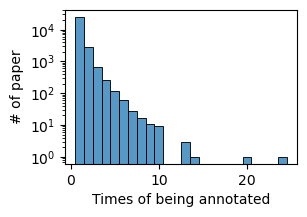

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

paper_id_counts = full['paper_id'].value_counts()
fig = plt.figure(figsize=(3, 2))
sns.histplot(x=paper_id_counts, bins=30, stat='count', discrete=True)
plt.yscale('log')
plt.xlabel('Times of being annotated')
plt.ylabel('# of paper')
plt.show()

In [11]:
fig.savefig(home / 'projects/TLDR/evaluation/ref_based/paper_annotated_times.pdf', bbox_inches='tight', dpi=300)

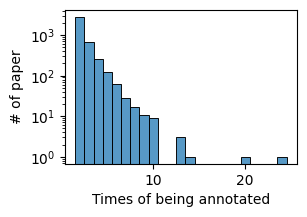

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

paper_id_counts = multi_annotated['paper_id'].value_counts()
plt.figure(figsize=(3, 2))
sns.histplot(x=paper_id_counts, bins=30, stat='count', discrete=True)
plt.yscale('log')
plt.xlabel('Times of being annotated')
plt.ylabel('# of paper')
plt.show()

In [ ]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    scores = evaluate_metrics(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(scores)

  0%|                                                                                                                                      | 0/10 [00:00<?, ?it/s][nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 10%|████████████▌                                                                                                                 | 1/10 [00:12<01:50, 12.32s/it][nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nl

In [ ]:
# 计算平均分
bleu_avg = sum(s['bleu'] for s in all_scores) / n_sample
meteor_avg = sum(s['meteor'] for s in all_scores) / n_sample
rouge_avg = {}
for rouge_type in ["rouge1", "rouge2", "rougeL"]:
    rouge_avg[rouge_type] = sum(s['rouge'][rouge_type] for s in all_scores) / n_sample

print("=== 10次抽样平均 ===")
print("BLEU: {:.4f}".format(bleu_avg))
print("METEOR: {:.4f}".format(meteor_avg))
print("ROUGE (F):")
for rouge_type in ["rouge1", "rouge2", "rougeL"]:
    print("  {}: {:.4f}".format(rouge_type.upper(), rouge_avg[rouge_type]))

=== 10次抽样平均 ===
BLEU: 0.0452
METEOR: 0.2159
ROUGE (F):
  ROUGE1: 0.2739
  ROUGE2: 0.0679
  ROUGEL: 0.2166


## Abstracts as references

In [9]:
evaluate_metrics(df, pred_col='gemma3', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.0006133061271783294,
 'rouge': {'rouge1': np.float64(0.19306453849239616),
  'rouge2': np.float64(0.07524048036774444),
  'rougeL': np.float64(0.13812604747936919)},
 'meteor': np.float64(0.10040613089886721)}

In [10]:
evaluate_metrics(df, pred_col='llama4', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.003487585346369448,
 'rouge': {'rouge1': np.float64(0.18779820422684113),
  'rouge2': np.float64(0.0615513947936469),
  'rougeL': np.float64(0.12630913326598375)},
 'meteor': np.float64(0.09422179709159398)}

In [ ]:
evaluate_metrics(df, pred_col='qwen3', ref_col='abstract')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.030714638745234092,
 'rouge': {'rouge1': 0.2494894076577696,
  'rouge2': 0.09113576218297251,
  'rougeL': 0.16591093974635696},
 'meteor': 0.13454828241954828}

In [15]:
evaluate_metrics(df, pred_col='annotation', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.00014032267591655747,
 'meteor': np.float64(0.06377415902193286),
 'rouge': {'rouge1': np.float64(0.1408848000436993),
  'rouge2': np.float64(0.03825775412279675),
  'rougeL': np.float64(0.10050406185966701)}}

# Simlarity-based

## BERTScore

In [5]:
from bert_score import score

def evaluate_bertscore(df, pred_col='prediction', ref_col='reference'):
    preds = df[pred_col].tolist()
    refs = df[ref_col].tolist()

    P, R, F1 = score(preds, refs, lang='en', 
                     use_fast_tokenizer=True,
                     batch_size=32,
                     verbose=True)
    print(f"BERTScore F1: {F1.mean().item():.4f}")
    return {
        "BERTScore_P": P.mean().item(),
        "BERTScore_R": R.mean().item(),
        "BERTScore_F1": F1.mean().item()
    }


### Human-wrtten annotations as references

#### LLMs' performance

In [16]:
evaluate_bertscore(df, pred_col='gemma3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2226 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 110.27 seconds, 323.05 sentences/sec
BERTScore F1: 0.8817


{'BERTScore_P': 0.8761969804763794,
 'BERTScore_R': 0.8877111673355103,
 'BERTScore_F1': 0.8817406296730042}

In [28]:
evaluate_bertscore(df, pred_col='llama4', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 316.19 seconds, 112.66 sentences/sec
BERTScore F1: 0.8771


{'BERTScore_P': 0.8746355772018433,
 'BERTScore_R': 0.8801242113113403,
 'BERTScore_F1': 0.8771476745605469}

In [7]:
evaluate_bertscore(df, pred_col='qwen3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2226 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 460.14 seconds, 77.41 sentences/sec
BERTScore F1: 0.8699


{'BERTScore_P': 0.8533397912979126,
 'BERTScore_R': 0.8875028491020203,
 'BERTScore_F1': 0.8699047565460205}

#### Multi-annotated papers as a human-evaluation baseline

In [30]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    scores = evaluate_bertscore(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(scores)

# 计算平均分
bertscore_avg = sum(s['BERTScore_F1'] for s in all_scores) / n_sample

print("=== 10次抽样平均 ===")
print("BERTScore: {:.4f}".format(bertscore_avg))

  0%|                                                                                    | 0/10 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 10%|███████▌                                                                    | 1/10 [00:38<05:50, 39.00s/it]

done in 37.19 seconds, 168.93 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 20%|███████████████▏                                                            | 2/10 [01:16<05:04, 38.12s/it]

done in 37.41 seconds, 167.90 sentences/sec
BERTScore F1: 0.8812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 30%|██████████████████████▊                                                     | 3/10 [01:55<04:28, 38.29s/it]

done in 37.74 seconds, 166.45 sentences/sec
BERTScore F1: 0.8812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 40%|██████████████████████████████▍                                             | 4/10 [02:33<03:50, 38.42s/it]

done in 37.65 seconds, 166.86 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 50%|██████████████████████████████████████                                      | 5/10 [03:12<03:12, 38.51s/it]

done in 37.83 seconds, 166.05 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████▌                              | 6/10 [03:50<02:33, 38.31s/it]

done in 37.71 seconds, 166.58 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████▏                      | 7/10 [04:28<01:55, 38.43s/it]

done in 37.82 seconds, 166.09 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████▊               | 8/10 [05:07<01:16, 38.48s/it]

done in 37.64 seconds, 166.84 sentences/sec
BERTScore F1: 0.8814


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [05:45<00:38, 38.45s/it]

done in 37.64 seconds, 166.86 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [06:24<00:00, 38.49s/it]

done in 37.97 seconds, 165.43 sentences/sec
BERTScore F1: 0.8813
=== 10次抽样平均 ===
BERTScore: 0.8812


### Abstracts as references

In [17]:
evaluate_bertscore(df, pred_col='gemma3', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2028 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 344.80 seconds, 103.31 sentences/sec
BERTScore F1: 0.8637


{'BERTScore_P': 0.9006731510162354,
 'BERTScore_R': 0.8299712538719177,
 'BERTScore_F1': 0.8637344837188721}

In [18]:
evaluate_bertscore(df, pred_col='llama4', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2028 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 360.11 seconds, 98.92 sentences/sec
BERTScore F1: 0.8565


{'BERTScore_P': 0.8925188183784485,
 'BERTScore_R': 0.8236910700798035,
 'BERTScore_F1': 0.8565149307250977}

In [8]:
evaluate_bertscore(df, pred_col='qwen3', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2028 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 1268.99 seconds, 28.07 sentences/sec
BERTScore F1: 0.8694


{'BERTScore_P': 0.8968477249145508,
 'BERTScore_R': 0.8439767956733704,
 'BERTScore_F1': 0.8694406151771545}

In [5]:
evaluate_bertscore(df, pred_col='annotation', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1014/1014 [05:34<00:00,  3.03it/s]


computing greedy matching.


100%|██████████| 557/557 [00:17<00:00, 31.90it/s]


done in 354.50 seconds, 100.48 sentences/sec
BERTScore F1: 0.8410


{'BERTScore_P': 0.8739364147186279,
 'BERTScore_R': 0.8107424378395081,
 'BERTScore_F1': 0.840957522392273}

## MoverScore

In [20]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(str(home / 'projects/TLDR/evaluation/ref_based'))

from moverscore_v2 import get_idf_dict, word_mover_score 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def evaluate_moverscore(df, pred_col='prediction', ref_col='reference'):
    preds = df[pred_col].tolist()
    refs = df[ref_col].tolist()

    idf_dict_hyp = get_idf_dict(preds)
    idf_dict_ref = get_idf_dict(refs)

    scores = word_mover_score(refs, preds, idf_dict_ref, idf_dict_hyp, stop_words=stopwords.words('english'))
    print(f'MoverScore: {np.mean(scores):.4f}')

    return np.mean(scores)

tokenizer.model_max_length:  512


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Human-written annotations as references

#### LLMs' performace

In [22]:
evaluate_moverscore(df, pred_col='gemma3', ref_col='annotation')

Token indices sequence length is longer than the specified maximum sequence length for this model (1152 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1541 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [02:32<00:00,  1.82it/s]

MoverScore: 0.5660


np.float64(0.566014325735857)

In [23]:
evaluate_moverscore(df, pred_col='llama4', ref_col='annotation')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [06:55<00:00,  1.49s/it]

MoverScore: 0.5593


np.float64(0.559332717702572)

In [20]:
evaluate_moverscore(df, pred_col='qwen3', ref_col='annotation')

Token indices sequence length is longer than the specified maximum sequence length for this model (2578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (41841 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (41493 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS: 100%|███████████████████████████████████████████████████████| 279/279 [1:26:58<00:00, 18.70s/it]

MoverScore: 0.5578


0.5578431509562374

#### Multi-annotated abstracts as a human-evaluation baseline

In [10]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    score = evaluate_moverscore(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(score)

# 计算平均分
moverscore_avg = np.mean(all_scores)

print("=== 10次抽样平均 ===")
print("MoverScore: {:.4f}".format(moverscore_avg))

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [07:18<00:00, 43.86s/it]

=== 10次抽样平均 ===
MoverScore: 0.5644


### Abstracts as references

In [24]:
evaluate_moverscore(df, pred_col='gemma3', ref_col='abstract')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [27:06<00:00,  5.83s/it]

MoverScore: 0.5524


np.float64(0.5523958961946267)

In [25]:
evaluate_moverscore(df, pred_col='llama4', ref_col='abstract')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [42:41<00:00,  9.18s/it]

MoverScore: 0.5438


np.float64(0.5438416908340507)

In [3]:
evaluate_moverscore(df, pred_col='qwen3', ref_col='abstract')

Token indices sequence length is longer than the specified maximum sequence length for this model (2578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (41841 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (41493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

MoverScore: 0.5681


0.5681377232282112

In [5]:
evaluate_moverscore(df, pred_col='annotation', ref_col='abstract')

Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS:   0%|          | 0/279 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
DistilBertSdpaAttention is used bu

np.float64(0.5301549328571855)